#### **Declare path to project directory**

In [52]:
path_to_directory = "/Users/tiago/Desktop/DS/data_science_project"

# **Data Preparation**

## **Variable Encoding**

In [ ]:
from pandas import read_csv, DataFrame
from dslabs_functions import get_variable_types, encode_cyclic_variables, dummify

data: DataFrame = read_csv("datasets/class_ny_arrests.csv", index_col="ARREST_KEY", na_values="")

jurisdiction_code: dict[str, int] = {"NY": 0, "nonNY": 1}
arrest_boro: dict[str, int] = {"Q": 1, "M": 2, "K": 3, "B": 4, "S": 5}
perp_races: dict[str, int] = {"UNKNOWN": 0, "BLACK": 1, "WHITE HISPANIC": 2, "BLACK HISPANIC": 3,
                              "WHITE": 4, "ASIAN / PACIFIC ISLANDER": 5, "AMERICAN INDIAN/ALASKAN NATIVE": 6, "OTHER": 7}
law_cat_cd: dict[str, int] = {"M": 0, "F": 1}

data['JURISDICTION_CODE'] = data['JURISDICTION_CODE'].apply(lambda x: 'NY' if x < 3 else 'nonNY')

encoding: dict[str, dict[str, int]] = {
    "ARREST_BORO": arrest_boro,
    "PERP_RACE": perp_races,
    "LAW_CAT_CD": law_cat_cd,
    "PERP_SEX": law_cat_cd,
    "JURISDICTION_CODE": jurisdiction_code,
}
data: DataFrame = data.replace(encoding, inplace=False)
data.head()

,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
ARREST_KEY,,,,,,,,,,,,,,,,,
32311380,06/18/2007,511.0,"CONTROLLED SUBSTANCE, POSSESSION 7",235.0,DANGEROUS DRUGS,PL 2200300,0,1.0,27,0,18-24,0,1,NaN,NaN,NaN,NaN
192799737,01/26/2019,177.0,SEXUAL ABUSE,116.0,SEX CRIMES,PL 1306503,1,2.0,25,0,45-64,0,1,1000555.0,230994.0,40.800694,-73.941109
193260691,02/06/2019,NaN,NaN,NaN,NaN,PL 2203400,1,2.0,14,0,25-44,0,0,986685.0,215375.0,40.757839,-73.991212
149117452,01/06/2016,153.0,RAPE 3,104.0,RAPE,PL 1302503,1,3.0,67,0,25-44,0,1,998032.0,175598.0,40.648650,-73.950336
190049060,11/15/2018,157.0,RAPE 1,104.0,RAPE,PL 1303501,1,3.0,77,0,25-44,0,1,1003606.0,185050.0,40.674583,-73.930222


In [54]:
age_group_mapping = {
    '<18': 1,
    '18-24': 2,
    '25-44': 3,
    '45-64': 4,
    '65+': 5,
    'UNKNOWN': 0
}

data["AGE_GROUP"] = data["AGE_GROUP"].apply(
    lambda x: age_group_mapping.get(x, 0)  # Map valid groups; default to 0 for invalid
)

data.head()

,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
ARREST_KEY,,,,,,,,,,,,,,,,,
32311380,06/18/2007,511.0,"CONTROLLED SUBSTANCE, POSSESSION 7",235.0,DANGEROUS DRUGS,PL 2200300,0,1.0,27,0,2,0,1,NaN,NaN,NaN,NaN
192799737,01/26/2019,177.0,SEXUAL ABUSE,116.0,SEX CRIMES,PL 1306503,1,2.0,25,0,4,0,1,1000555.0,230994.0,40.800694,-73.941109
193260691,02/06/2019,NaN,NaN,NaN,NaN,PL 2203400,1,2.0,14,0,3,0,0,986685.0,215375.0,40.757839,-73.991212
149117452,01/06/2016,153.0,RAPE 3,104.0,RAPE,PL 1302503,1,3.0,67,0,3,0,1,998032.0,175598.0,40.648650,-73.950336
190049060,11/15/2018,157.0,RAPE 1,104.0,RAPE,PL 1303501,1,3.0,77,0,3,0,1,1003606.0,185050.0,40.674583,-73.930222


In [55]:
import pandas as pd
from math import pi, sin, cos

# Função para codificar variáveis cíclicas
def encode_cyclic_variables(data: DataFrame, vars: list[str]) -> None:
    for v in vars:
        x_max = max(data[v])  # Valor máximo da variável
        data[v + "_sin"] = data[v].apply(lambda x: round(sin(2 * pi * x / x_max), 3))
        data[v + "_cos"] = data[v].apply(lambda x: round(cos(2 * pi * x / x_max), 3))
    return data

# Transformar a coluna "ARREST_DATE"
data["ARREST_DATE"] = pd.to_datetime(data["ARREST_DATE"], format="%m/%d/%Y")
data["Year"] = data["ARREST_DATE"].dt.year
data["Month"] = data["ARREST_DATE"].dt.month
data["Day"] = data["ARREST_DATE"].dt.day

# Criar variáveis cíclicas também para mês (opcional)
data = encode_cyclic_variables(data, ["Month"])

# Remover colunas originais (opcional)
data = data.drop(columns=["ARREST_DATE", "Month"])

data.head()

,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Year,Day,Month_sin,Month_cos
ARREST_KEY,,,,,,,,,,,,,,,,,,,,
32311380,511.0,"CONTROLLED SUBSTANCE, POSSESSION 7",235.0,DANGEROUS DRUGS,PL 2200300,0,1.0,27,0,2,0,1,NaN,NaN,NaN,NaN,2007,18,0.000,-1.000
192799737,177.0,SEXUAL ABUSE,116.0,SEX CRIMES,PL 1306503,1,2.0,25,0,4,0,1,1000555.0,230994.0,40.800694,-73.941109,2019,26,0.500,0.866
193260691,NaN,NaN,NaN,NaN,PL 2203400,1,2.0,14,0,3,0,0,986685.0,215375.0,40.757839,-73.991212,2019,6,0.866,0.500
149117452,153.0,RAPE 3,104.0,RAPE,PL 1302503,1,3.0,67,0,3,0,1,998032.0,175598.0,40.648650,-73.950336,2016,6,0.500,0.866
190049060,157.0,RAPE 1,104.0,RAPE,PL 1303501,1,3.0,77,0,3,0,1,1003606.0,185050.0,40.674583,-73.930222,2018,15,-0.500,0.866


In [56]:
# Remover colunas
data = data.drop(columns=["PD_DESC", "LAW_CODE"])

data.head()

,PD_CD,KY_CD,OFNS_DESC,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Year,Day,Month_sin,Month_cos
ARREST_KEY,,,,,,,,,,,,,,,,,,
32311380,511.0,235.0,DANGEROUS DRUGS,0,1.0,27,0,2,0,1,NaN,NaN,NaN,NaN,2007,18,0.000,-1.000
192799737,177.0,116.0,SEX CRIMES,1,2.0,25,0,4,0,1,1000555.0,230994.0,40.800694,-73.941109,2019,26,0.500,0.866
193260691,NaN,NaN,NaN,1,2.0,14,0,3,0,0,986685.0,215375.0,40.757839,-73.991212,2019,6,0.866,0.500
149117452,153.0,104.0,RAPE,1,3.0,67,0,3,0,1,998032.0,175598.0,40.648650,-73.950336,2016,6,0.500,0.866
190049060,157.0,104.0,RAPE,1,3.0,77,0,3,0,1,1003606.0,185050.0,40.674583,-73.930222,2018,15,-0.500,0.866


In [57]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Criando um LabelEncoder
label_encoder = LabelEncoder()

# Transformando os valores em inteiros
data['OFNS_DESC'] = label_encoder.fit_transform(data['OFNS_DESC'])

# Criando um LabelEncoder
label_encoder = LabelEncoder()

# Transformando os valores em inteiros
data['PD_CD'] = label_encoder.fit_transform(data['PD_CD'])

# Criando um LabelEncoder
label_encoder = LabelEncoder()

# Transformando os valores em inteiros
data['KY_CD'] = label_encoder.fit_transform(data['KY_CD'])

data.head()

,PD_CD,KY_CD,OFNS_DESC,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Year,Day,Month_sin,Month_cos
ARREST_KEY,,,,,,,,,,,,,,,,,,
32311380,114,30,14,0,1.0,27,0,2,0,1,NaN,NaN,NaN,NaN,2007,18,0.000,-1.000
192799737,33,14,66,1,2.0,25,0,4,0,1,1000555.0,230994.0,40.800694,-73.941109,2019,26,0.500,0.866
193260691,279,60,72,1,2.0,14,0,3,0,0,986685.0,215375.0,40.757839,-73.991212,2019,6,0.866,0.500
149117452,23,3,64,1,3.0,67,0,3,0,1,998032.0,175598.0,40.648650,-73.950336,2016,6,0.500,0.866
190049060,25,3,64,1,3.0,77,0,3,0,1,1003606.0,185050.0,40.674583,-73.930222,2018,15,-0.500,0.866


In [16]:
df: DataFrame = data.copy(deep=True)
df.to_csv(f"{path_to_directory}/datasets/class_ny_arrests_encoding.csv", index=False)
print(f"Data after encoding: {df.shape}")

Data after encoding: (4968684, 18)


<h3>Methodology After Variable Encoding</h3>

{'accuracy': [0.95075, 0.97655], 'recall': [0.06788247213779129, 0.7527862208713273], 'precision': [0.5075757575757576, 0.7675619834710744], 'auc': [0.5322318793129918, 0.8704761062806119], 'f1': [0.11974977658623771, 0.7601023017902814]}


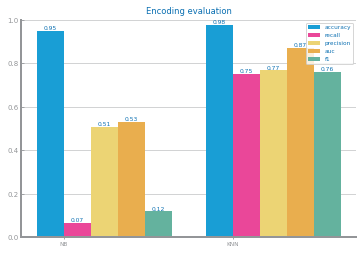

In [ ]:
from numpy import ndarray
from pandas import DataFrame, read_csv
from matplotlib.pyplot import savefig, show, figure
from dslabs_functions import plot_multibar_chart, CLASS_EVAL_METRICS, run_KNN, run_NB
from sklearn.model_selection import train_test_split
from dslabs_functions import DELTA_IMPROVE
from sklearn.naive_bayes import GaussianNB, BernoulliNB

def run_NB(trnX, trnY, tstX, tstY, metric: str = "accuracy") -> dict[str, float]:
    estimators: dict[str, GaussianNB | BernoulliNB] = {
        "GaussianNB": GaussianNB(),
        "BernoulliNB": BernoulliNB(),
    }
    best_model: GaussianNB | BernoulliNB = None
    best_performance: float = 0.0
    eval: dict[str, float] = {}

    for clf in estimators:
        estimators[clf].fit(trnX, trnY)
        prdY: ndarray = estimators[clf].predict(tstX)
        performance: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
        if performance - best_performance > DELTA_IMPROVE:
            best_performance = performance
            best_model = estimators[clf]
    if best_model is not None:
        prd: ndarray = best_model.predict(tstX)
        for key in CLASS_EVAL_METRICS:
            eval[key] = CLASS_EVAL_METRICS[key](tstY, prd)
    return eval

def evaluate_approach(
    train: DataFrame, test: DataFrame, target: str = "class", metric: str = "accuracy"
) -> dict[str, list]:
    trnY = train.pop(target).values
    trnX: ndarray = train.values
    tstY = test.pop(target).values
    tstX: ndarray = test.values
    eval: dict[str, list] = {}

    eval_NB: dict[str, float] = run_NB(trnX, trnY, tstX, tstY, metric=metric)
    eval_KNN: dict[str, float] = run_KNN(trnX, trnY, tstX, tstY, metric=metric)
    if eval_NB != {} and eval_KNN != {}:
        for met in CLASS_EVAL_METRICS:
            eval[met] = [eval_NB[met], eval_KNN[met]]
    return eval

target = "JURISDICTION_CODE"
file_tag = "class_ny_arrests"
filename = "datasets/class_ny_arrests.csv"

new_data: DataFrame = read_csv(f"{path_to_directory}/datasets/{file_tag}_encoding.csv")
new_data = new_data.dropna()

new_data = new_data.head(100000)

train, test = train_test_split(new_data, test_size=0.2, random_state=42)

figure()
eval_basic: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
print(eval_basic)
plot_multibar_chart(
    ["NB", "KNN"], eval_basic, title=f"Encoding evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/Set 1 - Encoding results.png")
show()

# **Variable Encoding**
## **Drop Missing Values**

In [59]:
# Eliminar missing values e "Unknowns" na idade
data: DataFrame = read_csv(f"{path_to_directory}/datasets/{file_tag}_encoding.csv", na_values="", index_col=None, sep=',', decimal='.')
data = data.dropna()

data = data[data['AGE_GROUP'] != 0]

data = data[data['OFNS_DESC'] != 72]

data = data[data['PERP_RACE'] != 0]

data = data[data['PD_CD'] != 279]

data = data[data['KY_CD'] != 60]

df: DataFrame = data.copy(deep=True)
df.to_csv(f"{path_to_directory}/datasets/{file_tag}_missing_values.csv", index=False)
print(f"Data after missing Values: {df.shape}")

Data after missing Values: (4911581, 18)


**Methodology of Missing Values**

{'accuracy': [0.953425, 0.9764], 'recall': [0.12526427061310783, 0.7367864693446089], 'precision': [0.5325842696629214, 0.7576086956521739], 'auc': [0.5599030495502821, 0.8625414450218374], 'f1': [0.20282413350449294, 0.7470525187566988]}


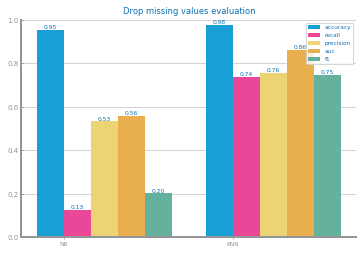

In [60]:
new_data: DataFrame = read_csv(f"{path_to_directory}/datasets/{file_tag}_missing_values.csv")
new_data = new_data.head(200000)

train, test = train_test_split(new_data, test_size=0.2, random_state=42)

figure()
eval_missing: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
print(eval_missing)
plot_multibar_chart(
    ["NB", "KNN"], eval_missing, title=f"Drop missing values evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/Set 1 - Drop missing values results.png")
show()

## **Filling missing values**

In [20]:
# Eliminar missing values e "Unknowns" na idade
data: DataFrame = read_csv(f"{path_to_directory}/datasets/{file_tag}_encoding.csv", na_values="", index_col=None, sep=',', decimal='.')

data = data.fillna(data.mean())

df: DataFrame = data.copy(deep=True)
df.to_csv(f"{path_to_directory}/datasets/{file_tag}_filling_values.csv", index=False)
print(f"Data after missing Values: {df.shape}")

Data after missing Values: (4968684, 18)


**Methodology of Filling Values**

{'accuracy': [0.953525, 0.977275], 'recall': [0.11885467314964884, 0.7477039438141545], 'precision': [0.49107142857142855, 0.7579408543263965], 'auc': [0.556439053788906, 0.8680588973834987], 'f1': [0.19138755980861244, 0.7527875985858037]}


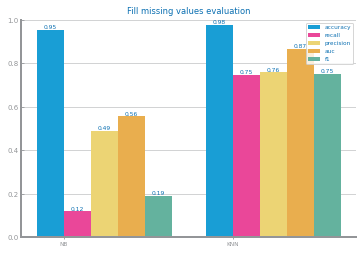

In [61]:
new_data: DataFrame = read_csv(f"{path_to_directory}/datasets/{file_tag}_filling_values.csv")
new_data = new_data.head(200000)

train, test = train_test_split(new_data, test_size=0.2, random_state=42)

figure()
eval_filling: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
print(eval_filling)
plot_multibar_chart(
    ["NB", "KNN"], eval_filling, title=f"Fill missing values evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/Set 1 - Fill missing values results.png")
show()

### Outlier method evaluation

In [62]:
evaluations = {"original": eval_basic, "missing": eval_missing, "filling": eval_filling}

best_mean = -float("inf")
best_mean_NB = -float("inf")
best_mean_KNN = -float("inf")
best_eval = None
best_eval_NB = None
best_eval_KNN = None
best_eval_dict = None

for eval_name, eval_dict in evaluations.items():
    # Calculate mean for NB and KNN using generator expressions
    mean_NB = sum(eval_dict[metric][0] for metric in ["accuracy", "recall", "precision", "auc", "f1"]) / 5
    mean_KNN = sum(eval_dict[metric][1] for metric in ["accuracy", "recall", "precision", "auc", "f1"]) / 5
    
    # Print means
    print(f"{eval_name}: Mean NB = {mean_NB}, Mean KNN = {mean_KNN}")

    # Update the best mean for NB
    if mean_NB > best_mean_NB:
        best_mean_NB = mean_NB
        best_eval_NB = eval_name

    # Update the best mean for KNN
    if mean_KNN > best_mean_KNN:
        best_mean_KNN = mean_KNN
        best_eval_KNN = eval_name

# Print the best mean scores
print(f"\nBest Mean NB: {best_mean_NB} from {best_eval_NB}")
print(f"Best Mean KNN: {best_mean_KNN} from {best_eval_KNN}")

if best_mean_NB > best_mean_KNN:
    best_mean = best_mean_NB
    best_eval = best_eval_NB
else:
    best_mean = best_mean_KNN
    best_eval = best_eval_KNN

print(f"\nContinuing with {best_eval} with mean {best_mean}")

# Determine the filename based on the best evaluations
if best_eval == "original":
    filename = f"{path_to_directory}/datasets/{file_tag}_encoding.csv"
    best_eval_dict = eval_basic
elif best_eval == "missing":
    filename = f"{path_to_directory}/datasets/{file_tag}_missing_values.csv"
    best_eval_dict = eval_missing
elif best_eval == "filling":
    filename = f"{path_to_directory}/datasets/{file_tag}_filling_values.csv"
    best_eval_dict = eval_filling

original: Mean NB = 0.4356379771225557, Mean KNN = 0.825495322482659
missing: Mean NB = 0.47480014466616083, Mean KNN = 0.8160778257550637
filling: Mean NB = 0.4622555430637192, Mean KNN = 0.8207532588219706

Best Mean NB: 0.47480014466616083 from missing
Best Mean KNN: 0.825495322482659 from original

Continuing with original with mean 0.825495322482659


Droping the missing values has a litle better values, so we will use that one

## **Outliers Inputation**
<h3>Drop Outliers</h3>

In [23]:
from pandas import read_csv, DataFrame, Series
from dslabs_functions import (
    NR_STDEV,
    get_variable_types,
    determine_outlier_thresholds_for_var,
)

data: DataFrame = read_csv(f"{path_to_directory}/datasets/{file_tag}_missing_values.csv")

print(f"Original train data: {data.shape}")

n_std: int = NR_STDEV
n_std = 9
print("n_std=", n_std)

numeric_vars: list[str] = get_variable_types(data)["numeric"]

if numeric_vars is not None:
    df: DataFrame = data.copy(deep=True)
    summary5: DataFrame = data[numeric_vars].describe()
    for var in numeric_vars:
        top_threshold, bottom_threshold = determine_outlier_thresholds_for_var(
            summary5[var], threshold= n_std
        )
        outliers: Series = df[(df[var] > top_threshold) | (df[var] < bottom_threshold)]
        df.drop(outliers.index, axis=0, inplace=True)
    df.to_csv(f"{path_to_directory}/datasets/{file_tag}_drop_outliers.csv", index=False)
    print(f"Data after dropping outliers: {df.shape}")
else:
    print("There are no numeric variables")


Original train data: (4911581, 18)
n_std= 9
Data after dropping outliers: (4905947, 18)


**Methodology of Droping Outliers**

{'accuracy': [0.953425, 0.9764], 'recall': [0.12526427061310783, 0.7367864693446089], 'precision': [0.5325842696629214, 0.7576086956521739], 'auc': [0.5599030495502821, 0.8625414450218374], 'f1': [0.20282413350449294, 0.7470525187566988]}


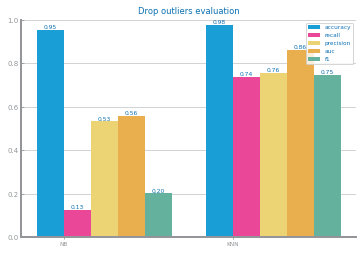

In [63]:
new_data: DataFrame = read_csv(f"{path_to_directory}/datasets/{file_tag}_drop_outliers.csv", na_values="", index_col=None, sep=',', decimal='.')
new_data = new_data.head(200000)

train, test = train_test_split(new_data, test_size=0.2, random_state=42)

figure()
eval_dropping: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
print(eval_dropping)
plot_multibar_chart(
    ["NB", "KNN"], eval_dropping, title=f"Drop outliers evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/Set 1 - Outliers first approach (drop) results.png")
show()

<h3>Replacing outliers with fixed value</h3>

In [25]:
if [] != numeric_vars:
    df: DataFrame = data.copy(deep=True)
    for var in numeric_vars:
        top, bottom = determine_outlier_thresholds_for_var(summary5[var])
        median: float = df[var].median()
        df[var] = df[var].apply(lambda x: median if x > top or x < bottom else x)
    df.to_csv(f"{path_to_directory}/datasets/{file_tag}_replacing_outliers.csv", index=False)
    print("Data after replacing outliers:", df.shape)
    print(df.describe())
else:
    print("There are no numeric variables")


Data after replacing outliers: (4911581, 18)
              PD_CD         KY_CD     OFNS_DESC    LAW_CAT_CD   ARREST_BORO  \
count  4.911581e+06  4.911581e+06  4.911581e+06  4.911581e+06  4.911581e+06   
mean   1.222021e+02  3.070827e+01  3.184675e+01  2.975767e-01  2.603482e+00   
std    8.555396e+01  1.466663e+01  2.226760e+01  4.571923e-01  1.043173e+00   
min    1.000000e+00  2.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00   
25%    6.100000e+01  1.900000e+01  1.400000e+01  0.000000e+00  2.000000e+00   
50%    1.080000e+02  3.100000e+01  2.000000e+01  0.000000e+00  3.000000e+00   
75%    1.970000e+02  4.000000e+01  5.500000e+01  1.000000e+00  3.000000e+00   
max    2.780000e+02  5.900000e+01  7.100000e+01  1.000000e+00  4.000000e+00   

       ARREST_PRECINCT  JURISDICTION_CODE     AGE_GROUP      PERP_SEX  \
count     4.911581e+06       4.911581e+06  4.911581e+06  4.911581e+06   
mean      6.085427e+01       2.594419e-02  2.923338e+00  1.752485e-01   
std       3.414311e+01  

**Methodology of Replacing Outliers**

{'accuracy': [0.952575, 0.976075], 'recall': [0.0015856236786469344, 0.7367864693446089], 'precision': [0.2727272727272727, 0.7522935779816514], 'auc': [0.5006878470025438, 0.8623708771620704], 'f1': [0.0031529164477141353, 0.7444592790387184]}


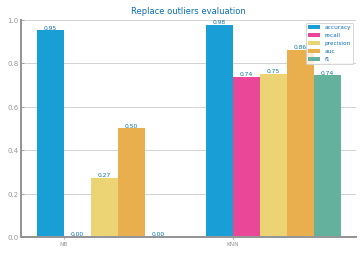

In [64]:
new_data: DataFrame = read_csv(f"{path_to_directory}/datasets/{file_tag}_replacing_outliers.csv", na_values="", index_col=None, sep=',', decimal='.')
new_data = new_data.head(200000)

train, test = train_test_split(new_data, test_size=0.2, random_state=42)

figure()
eval_replacing: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
print(eval_replacing)
plot_multibar_chart(
    ["NB", "KNN"], eval_replacing, title=f"Replace outliers evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/Set 1 - Outliers second approach (replacing) results.png")
show()

<h3>Truncate outliers</h3>

In [27]:
if [] != numeric_vars:
    df: DataFrame = data.copy(deep=True)
    for var in numeric_vars:
        top, bottom = determine_outlier_thresholds_for_var(summary5[var])
        df[var] = df[var].apply(
            lambda x: top if x > top else bottom if x < bottom else x
        )
    df.to_csv(f"{path_to_directory}/datasets/{file_tag}_truncate_outliers.csv", index=False)
    print("Data after truncating outliers:", df.shape)
    print(df.describe())
else:
    print("There are no numeric variables")


Data after truncating outliers: (4911581, 18)
              PD_CD         KY_CD     OFNS_DESC    LAW_CAT_CD   ARREST_BORO  \
count  4.911581e+06  4.911581e+06  4.911581e+06  4.911581e+06  4.911581e+06   
mean   1.222021e+02  3.061062e+01  3.184675e+01  2.975767e-01  2.677175e+00   
std    8.555396e+01  1.476370e+01  2.226760e+01  4.571923e-01  1.133654e+00   
min    1.000000e+00  1.065720e+00  0.000000e+00  0.000000e+00  1.000000e+00   
25%    6.100000e+01  1.900000e+01  1.400000e+01  0.000000e+00  2.000000e+00   
50%    1.080000e+02  3.100000e+01  2.000000e+01  0.000000e+00  3.000000e+00   
75%    1.970000e+02  4.000000e+01  5.500000e+01  1.000000e+00  4.000000e+00   
max    2.780000e+02  5.900000e+01  7.100000e+01  1.000000e+00  4.953367e+00   

       ARREST_PRECINCT  JURISDICTION_CODE     AGE_GROUP      PERP_SEX  \
count     4.911581e+06       4.911581e+06  4.911581e+06  4.911581e+06   
mean      6.085427e+01       2.594419e-02  2.773291e+00  1.752485e-01   
std       3.414311e+01 

**Methodology of Truncating Outliers**

{'accuracy': [0.9521, 0.976125], 'recall': [0.12790697674418605, 0.7362579281183932], 'precision': [0.4763779527559055, 0.7533802055164954], 'auc': [0.5604634075491687, 0.8621459683627549], 'f1': [0.20166666666666666, 0.7447206629243517]}


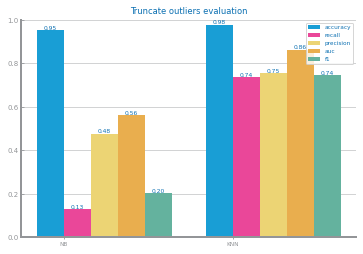

In [65]:
new_data: DataFrame = read_csv(f"{path_to_directory}/datasets/{file_tag}_truncate_outliers.csv", na_values="", index_col=None, sep=',', decimal='.')
new_data = new_data.head(200000)

train, test = train_test_split(new_data, test_size=0.2, random_state=42)

figure()
eval_truncate: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
print(eval_truncate)
plot_multibar_chart(
    ["NB", "KNN"], eval_truncate, title=f"Truncate outliers evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/Set 1 - Outliers third approach (truncate) results.png")
show()

### Outlier method evaluation

In [66]:
evaluations = {"original": eval_missing, "drop": eval_dropping, "replacing": eval_replacing, "truncate": eval_truncate}

best_mean = -float("inf")
best_mean_NB = -float("inf")
best_mean_KNN = -float("inf")
best_eval = None
best_eval_NB = None
best_eval_KNN = None
best_eval_dict = None

for eval_name, eval_dict in evaluations.items():
    # Calculate mean for NB and KNN using generator expressions
    mean_NB = sum(eval_dict[metric][0] for metric in ["accuracy", "recall", "precision", "auc", "f1"]) / 5
    mean_KNN = sum(eval_dict[metric][1] for metric in ["accuracy", "recall", "precision", "auc", "f1"]) / 5
    
    # Print means
    print(f"{eval_name}: Mean NB = {mean_NB}, Mean KNN = {mean_KNN}")

    # Update the best mean for NB
    if mean_NB > best_mean_NB:
        best_mean_NB = mean_NB
        best_eval_NB = eval_name

    # Update the best mean for KNN
    if mean_KNN > best_mean_KNN:
        best_mean_KNN = mean_KNN
        best_eval_KNN = eval_name

# Print the best mean scores
print(f"\nBest Mean NB: {best_mean_NB} from {best_eval_NB}")
print(f"Best Mean KNN: {best_mean_KNN} from {best_eval_KNN}")

if best_mean_NB > best_mean_KNN:
    best_mean = best_mean_NB
    best_eval = best_eval_NB
else:
    best_mean = best_mean_KNN
    best_eval = best_eval_KNN

print(f"\nContinuing with {best_eval} with mean {best_mean}")

# Determine the filename based on the best evaluations
if best_eval == "original":
    filename = f"{path_to_directory}/datasets/{file_tag}_missing_values.csv"
    best_eval_dict = eval_missing
elif best_eval == "drop":
    filename = f"{path_to_directory}/datasets/{file_tag}_drop_outliers.csv"
    best_eval_dict = eval_dropping
elif best_eval == "replacing":
    filename = f"{path_to_directory}/datasets/{file_tag}_replacing_outliers.csv"
    best_eval_dict = eval_replacing
elif best_eval == "truncate":
    filename = f"{path_to_directory}/datasets/{file_tag}_truncate_outliers.csv"
    best_eval_dict = eval_truncate

original: Mean NB = 0.47480014466616083, Mean KNN = 0.8160778257550637
drop: Mean NB = 0.47480014466616083, Mean KNN = 0.8160778257550637
replacing: Mean NB = 0.3461457319712355, Mean KNN = 0.8143970407054099
truncate: Mean NB = 0.4637030007431854, Mean KNN = 0.814525952984399

Best Mean NB: 0.47480014466616083 from original
Best Mean KNN: 0.8160778257550637 from original

Continuing with original with mean 0.8160778257550637


After seeing every diferent case of dealing with the outliers we see that the values don´t improve in any of the cases, so we will keep the missing values dataset.

## **Scaling**
<h3>Methodollogy MinMax Scaler</h3>

In [30]:
from pandas import read_csv, DataFrame, Series
from sklearn.preprocessing import StandardScaler

data: DataFrame = read_csv(f"{path_to_directory}/datasets/{file_tag}_missing_values.csv")

target = "JURISDICTION_CODE"

# Separate the target column
target_data: Series = data.pop(target).copy()  # Use .copy() to ensure immutability

# Scale only the feature variables
scaler = StandardScaler(with_mean=True, with_std=True, copy=True)
scaled_features = scaler.fit_transform(data)

# Create a DataFrame for the scaled data
df_zscore = DataFrame(scaled_features, columns=data.columns, index=data.index)

# Insert the target variable at the 6th index
df_zscore.insert(6, target, target_data)

# Save the final DataFrame
df_zscore.to_csv(f"{path_to_directory}/datasets/{file_tag}_scaled_zscore.csv", index=False)

<h3>Methodollogy Standard Scaler</h3>

{'accuracy': [0.9361], 'recall': [0.3118393234672304], 'precision': [0.3199566160520607], 'auc': [0.6394664235684004], 'f1': [0.31584582441113485]}


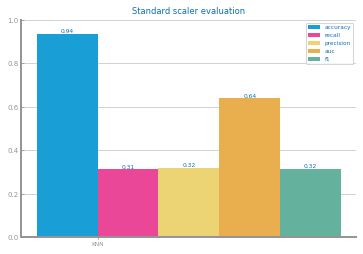

In [67]:
from numpy import ndarray
from pandas import DataFrame, read_csv
from matplotlib.pyplot import savefig, show, figure
from dslabs_functions import plot_multibar_chart, CLASS_EVAL_METRICS, run_KNN
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from dslabs_functions import DELTA_IMPROVE

def evaluate_approach2(
    train: DataFrame, test: DataFrame, target: str = "class", metric: str = "accuracy"
) -> dict[str, list]:
    # Separate features and target variables
    trnY = train.pop(target).values
    trnX: ndarray = train.values
    tstY = test.pop(target).values
    tstX: ndarray = test.values

    # Evaluate KNN
    eval_KNN: dict[str, float] = run_KNN(trnX, trnY, tstX, tstY, metric=metric)
    
    # Create evaluation dictionary
    eval: dict[str, list] = {}
    for met in CLASS_EVAL_METRICS:
        eval[met] = [eval_KNN[met]]  # Only store KNN results as a single-entry list

    return eval

new_data: DataFrame = read_csv(f"{path_to_directory}/datasets/{file_tag}_scaled_zscore.csv")
new_data = new_data.head(200000)

train, test = train_test_split(new_data, test_size=0.2, random_state=42)

figure()
eval_standart: dict[str, list] = evaluate_approach2(train, test, target=target, metric="recall")
print(eval_standart)
plot_multibar_chart(
    ["KNN"], eval_standart, title="Standard scaler evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/Set 1 - z-score KNN results.png")
show()

<h3>MinMax Scaler</h3>

In [32]:
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, Series, read_csv

# Load data
data: DataFrame = read_csv(f"{path_to_directory}/datasets/{file_tag}_drop_outliers.csv")

target = "JURISDICTION_CODE"
vars: list[str] = data.columns.to_list()

# Separate target column
target_data: Series = data.pop(target).copy()

# Apply MinMaxScaler to the remaining columns
transf: MinMaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(data)
df_minmax = DataFrame(transf.transform(data), index=data.index, columns=data.columns)

# Reinsert the target column at the 6th index
df_minmax.insert(6, target, target_data)

# Rename columns to match original variable names
df_minmax.columns = vars

# Save the resulting DataFrame
df_minmax.to_csv(f"{path_to_directory}/datasets/{file_tag}_scaled_minmax.csv", index=False)

<h3>Methodollogy MinMax Scaler</h3>

{'accuracy': [0.934], 'recall': [0.2832980972515856], 'precision': [0.2945054945054945], 'auc': [0.6248021923226544], 'f1': [0.2887931034482759]}


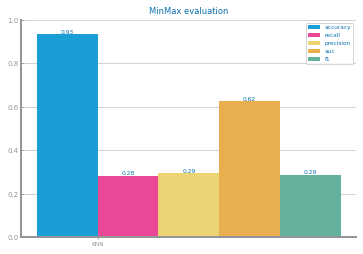

In [68]:
new_data: DataFrame = read_csv(f"{path_to_directory}/datasets/{file_tag}_scaled_minmax.csv", na_values="", index_col=None, sep=',', decimal='.')
new_data = new_data.head(200000)

train, test = train_test_split(new_data, test_size=0.2, random_state=42)

figure()
eval_minmax: dict[str, list] = evaluate_approach2(train, test, target=target, metric="recall")
print(eval_minmax)
plot_multibar_chart(
    ["KNN"], eval_minmax, title="MinMax evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/Set 1 - min-max KNN results.png")
show()

### Transformed data in boxplot

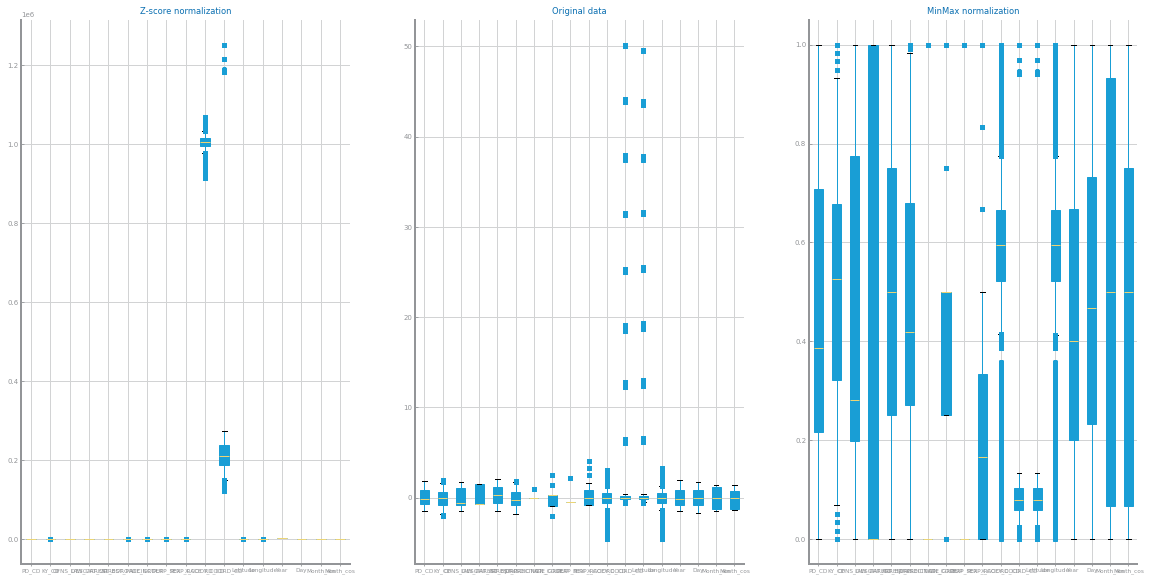

In [41]:
from matplotlib.pyplot import subplots, show

fig, axs = subplots(1, 3, figsize=(20, 10), squeeze=False)
axs[0, 1].set_title("Original data")
data.boxplot(ax=axs[0, 0])
axs[0, 0].set_title("Z-score normalization")
df_zscore.boxplot(ax=axs[0, 1])
axs[0, 2].set_title("MinMax normalization")
df_minmax.boxplot(ax=axs[0, 2])
show()

### Scaling method evaluation

In [69]:
evaluations = {"missing": eval_missing, "standard_scaler": eval_standart, "minmax": eval_minmax}

aux_best_eval = best_eval
best_mean = -float("inf")
mean = -float("inf")
best_eval = None

for eval_name, eval_dict in evaluations.items():
    if eval_name == "missing":
        mean = sum(eval_dict[metric][1] for metric in ["accuracy", "recall", "precision", "auc", "f1"]) / 5
    else:
        mean = sum(eval_dict[metric][0] for metric in ["accuracy", "recall", "precision", "auc", "f1"]) / 5
    
    # Print means
    print(f"{eval_name}: Mean = {mean}")

    # Update the best mean
    if mean > best_mean:
        best_mean = mean
        best_eval = eval_name

# Print the best mean scores
print(f"\nContinuing with {best_eval} with mean {best_mean}")

# Determine the filename based on the best evaluations
if best_eval == f"{aux_best_eval}":
    filename = f"{path_to_directory}/datasets/{file_tag}_missing_values.csv"
    best_eval_dict = eval_missing
elif best_eval == "standard_scaler":
    filename = f"{path_to_directory}/datasets/{file_tag}_scaled_zscore.csv"
    best_eval_dict = eval_standart
elif best_eval == "minmax":
    filename = f"{path_to_directory}/datasets/{file_tag}_scaled_minmax.csv"
    best_eval_dict = eval_minmax

missing: Mean = 0.8160778257550637
standard_scaler: Mean = 0.5046416374997653
minmax: Mean = 0.4850797775056021

Continuing with missing with mean 0.8160778257550637


Surprisingly, scaling didn't improve the results, so we won't use it.

# **Feature Engineering**
## **Feature Selection**
### Dropping Low Variance Variables


In [70]:
from pandas import DataFrame, Index, read_csv
from dslabs_functions import (
    select_low_variance_variables,
    study_variance_for_feature_selection,
    apply_feature_selection,
    select_redundant_variables,
    study_redundancy_for_feature_selection,
)


def select_low_variance_variables(
    data: DataFrame, max_threshold: float, target: str = "class"
) -> list:
    summary5: DataFrame = data.describe()
    vars2drop: Index[str] = summary5.columns[
        summary5.loc["std"] * summary5.loc["std"] < max_threshold
    ]
    vars2drop = vars2drop.drop(target) if target in vars2drop else vars2drop
    return list(vars2drop.values)


target = "JURISDICTION_CODE"
train: DataFrame = read_csv(filepath_or_buffer=filename)

print("Original variables", train.columns.to_list())
vars2drop: list[str] = select_low_variance_variables(train, 3, target=target)
print("Variables to drop", vars2drop)

Original variables ['PD_CD', 'KY_CD', 'OFNS_DESC', 'LAW_CAT_CD', 'ARREST_BORO', 'ARREST_PRECINCT', 'JURISDICTION_CODE', 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude', 'Year', 'Day', 'Month_sin', 'Month_cos']
Variables to drop ['LAW_CAT_CD', 'ARREST_BORO', 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'Latitude', 'Longitude', 'Month_sin', 'Month_cos']


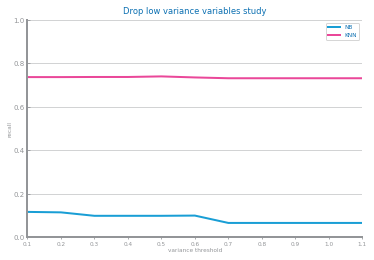

In [71]:
from math import ceil
from matplotlib.pyplot import savefig, show, figure
from dslabs_functions import HEIGHT, plot_multiline_chart
from pandas import Index


def evaluate_approach(
    train: DataFrame, test: DataFrame, target: str = "class", metric: str = "accuracy"
) -> dict[str, list]:
    trnY = train.pop(target).values
    trnX: ndarray = train.values
    tstY = test.pop(target).values
    tstX: ndarray = test.values
    eval: dict[str, list] = {}

    eval_NB: dict[str, float] = run_NB(trnX, trnY, tstX, tstY, metric=metric)
    eval_KNN: dict[str, float] = run_KNN(trnX, trnY, tstX, tstY, metric=metric)
    if eval_NB != {} and eval_KNN != {}:
        for met in CLASS_EVAL_METRICS:
            eval[met] = [eval_NB[met], eval_KNN[met]]
    return eval

def study_variance_for_feature_selection(
    train: DataFrame,
    test: DataFrame,
    target: str = "class",
    max_threshold: float = 1,
    lag: float = 0.05,
    metric: str = "accuracy",
    file_tag: str = "",
) -> dict:
    options: list[float] = [
        round(i * lag, 3) for i in range(1, ceil(max_threshold / lag + lag))
    ]
    results: dict[str, list] = {"NB": [], "KNN": []}
    summary5: DataFrame = train.describe()
    for thresh in options:
        vars2drop: Index[str] = summary5.columns[
            summary5.loc["std"] * summary5.loc["std"] < thresh
        ]
        vars2drop = vars2drop.drop(target) if target in vars2drop else vars2drop

        train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
        test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
        eval: dict[str, list] | None = evaluate_approach(
            train_copy, test_copy, target=target, metric=metric
        )
        if eval is not None:
            results["NB"].append(eval[metric][0])
            results["KNN"].append(eval[metric][1])

    plot_multiline_chart(
        options,
        results,
        title=f"Drop low variance variables study",
        xlabel="variance threshold",
        ylabel=metric,
        percentage=True,
    )
    savefig(f"{path_to_directory}/images/Set 1 - Drop low variance variables study.png")
    return results

target = "JURISDICTION_CODE"
train: DataFrame = read_csv(filepath_or_buffer=filename)

eval_metric = "recall"
train = train.head(200000)
train, test = train_test_split(train, test_size=0.2, random_state=42)

figure()
study_variance_for_feature_selection(
    train,
    test,
    target=target,
    max_threshold=1.1,
    lag=0.1,
    metric=eval_metric,
    file_tag=file_tag,
)
show()

In [72]:
def apply_feature_selection(
    train: DataFrame,
    test: DataFrame,
    vars2drop: list,
    filename: str = "",
    tag: str = "",
) -> tuple[DataFrame, DataFrame]:
    train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
    train_copy.to_csv(f"{filename}_train_{tag}.csv", index=False)
    test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
    test_copy.to_csv(f"{filename}_test_{tag}.csv", index=False)
    return train_copy, test_copy


vars2drop: list[str] = select_low_variance_variables(
    train, max_threshold=0.9, target=target
)
train_cp, test_cp = apply_feature_selection(
    train, test, vars2drop, filename=f"{path_to_directory}/datasets/{file_tag}", tag="lowvar"
)
print(f"Original data: train={train.shape}, test={test.shape}")
print(f"After low variance FS: train_cp={train_cp.shape}, test_cp={test_cp.shape}")

Original data: train=(160000, 18), test=(40000, 18)
After low variance FS: train_cp=(160000, 10), test_cp=(40000, 10)


Methodology

{'accuracy': [0.951925, 0.97625], 'recall': [0.0660676532769556, 0.7315010570824524], 'precision': [0.44483985765124556, 0.7579408543263965], 'auc': [0.530987012321274, 0.8599512213091488], 'f1': [0.11504832029452369, 0.7444862829478215]}


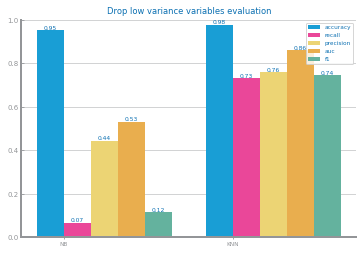

In [ ]:
figure()
eval_lowvar: dict[str, list] = evaluate_approach(train_cp, test_cp, target=target, metric="recall")
print(eval_lowvar)
plot_multibar_chart(
    ["NB", "KNN"], eval_lowvar, title="Drop low variance variables evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/Set 1 - Drop low variance variables results.png")
show()

### Dropping Redundant Variables

In [74]:
from pandas import Series

def select_redundant_variables(
    data: DataFrame, min_threshold: float = 0.90, target: str = "class"
) -> list:
    df: DataFrame = data.drop(target, axis=1, inplace=False)
    corr_matrix: DataFrame = abs(df.corr())
    variables: Index[str] = corr_matrix.columns
    vars2drop: list = []
    for v1 in variables:
        if v1 not in vars2drop:
            vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= min_threshold]
            vars_corr.drop(v1, inplace=True)
            if len(vars_corr) > 0:
                lst_corr = list(vars_corr.index)
                for v2 in lst_corr:
                    if v2 not in vars2drop:
                        vars2drop.append(v2)
    return vars2drop

print("Original variables", train.columns.values)
vars2drop: list[str] = select_redundant_variables(
    train, target=target, min_threshold=0.5
)
print("Variables to drop", vars2drop)

Original variables ['PD_CD' 'KY_CD' 'OFNS_DESC' 'LAW_CAT_CD' 'ARREST_BORO' 'ARREST_PRECINCT'
 'JURISDICTION_CODE' 'AGE_GROUP' 'PERP_SEX' 'PERP_RACE' 'X_COORD_CD'
 'Y_COORD_CD' 'Latitude' 'Longitude' 'Year' 'Day' 'Month_sin' 'Month_cos']
Variables to drop ['LAW_CAT_CD', 'Longitude', 'Latitude']


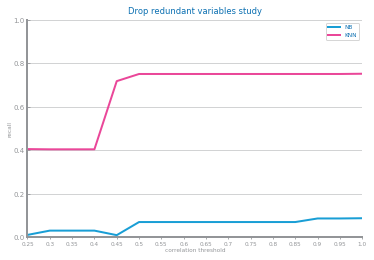

In [ ]:
def study_redundancy_for_feature_selection(
    train: DataFrame,
    test: DataFrame,
    target: str = "class",
    min_threshold: float = 0.90,
    lag: float = 0.05,
    metric: str = "accuracy",
    file_tag: str = "",
) -> dict:
    options: list[float] = [
        round(min_threshold + i * lag, 3)
        for i in range(ceil((1 - min_threshold) / lag) + 1)
    ]

    # Create a list to track valid thresholds
    valid_thresholds = []

    df: DataFrame = train.drop(target, axis=1, inplace=False)
    corr_matrix: DataFrame = abs(df.corr())
    variables: Index[str] = corr_matrix.columns
    results: dict[str, list] = {"NB": [], "KNN": []}
    for thresh in options:
        vars2drop: list = []
        for v1 in variables:
            if v1 not in vars2drop:
                vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= thresh]
                vars_corr.drop(v1, inplace=True)
                if len(vars_corr) > 0:
                    lst_corr = list(vars_corr.index)
                    for v2 in lst_corr:
                        if v2 not in vars2drop:
                            vars2drop.append(v2)

        train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
        test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
        eval: dict | None = evaluate_approach(
            train_copy, test_copy, target=target, metric=metric
        )
        if eval:  # Check if eval is not empty
            valid_thresholds.append(thresh)
            results["NB"].append(eval[metric][0])
            results["KNN"].append(eval[metric][1])
        else:
            print(f"Skipping threshold {thresh} due to empty evaluation results.")

    plot_multiline_chart(
        # options,
        valid_thresholds,
        results,
        title=f"Drop redundant variables study",
        xlabel="correlation threshold",
        ylabel=metric,
        percentage=True,
    )
    savefig(f"{path_to_directory}/images/Set 1 - Drop redundant variables study.png")
    return results


target = "JURISDICTION_CODE"
train: DataFrame = read_csv(filepath_or_buffer=filename)
train = train.head(100000)

eval_metric = "recall"
train, test = train_test_split(train, test_size=0.2, random_state=42)

# figure(figsize=(2 * HEIGHT, HEIGHT))
figure()
study_redundancy_for_feature_selection(
    train,
    test,
    target=target,
    min_threshold=0.25,
    lag=0.05,
    metric=eval_metric,
    file_tag=file_tag,
)
show()

In [76]:
vars2drop: list[str] = select_redundant_variables(
    train, min_threshold=0.8, target=target
)
train_cp, test_cp = apply_feature_selection(
    train, test, vars2drop, filename=f"{path_to_directory}/datasets/{file_tag}", tag="redundant"
)
print(f"Original data: train={train.shape}, test={test.shape}")
print(f"After redundant FS: train_cp={train_cp.shape}, test_cp={test_cp.shape}")

Original data: train=(80000, 18), test=(20000, 18)
After redundant FS: train_cp=(80000, 15), test_cp=(20000, 15)


Methodology

{'accuracy': [0.95515, 0.97715], 'recall': [0.07017543859649122, 0.7510964912280702], 'precision': [0.5663716814159292, 0.7486338797814208], 'auc': [0.5338041903795532, 0.8695235180364994], 'f1': [0.1248780487804878, 0.7498631636562672]}


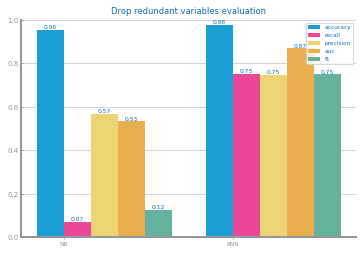

In [78]:
figure()
eval_redundant: dict[str, list] = evaluate_approach(train_cp, test_cp, target=target, metric="recall")
print(eval_redundant)
plot_multibar_chart(
    ["NB", "KNN"], eval_redundant, title="Drop redundant variables evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/Set 1 - Drop redundant variables results.png")
show()

### Feature Engineering method evaluation
Assuming the best_eval comes from missing values

In [ ]:
evaluations = {"original": eval_missing, "lowvar": eval_lowvar, "redundant": eval_redundant}

aux_best_eval = best_eval
best_mean = -float("inf")
best_mean_NB = -float("inf")
best_mean_KNN = -float("inf")
best_eval = None
best_eval_NB = None
best_eval_KNN = None

for eval_name, eval_dict in evaluations.items():
    # Calculate mean for NB and KNN using generator expressions
    mean_NB = sum(eval_dict[metric][0] for metric in ["accuracy", "recall", "precision", "auc", "f1"]) / 5
    mean_KNN = sum(eval_dict[metric][1] for metric in ["accuracy", "recall", "precision", "auc", "f1"]) / 5
    
    # Print means
    print(f"{eval_name}: Mean NB = {mean_NB}, Mean KNN = {mean_KNN}")

    # Update the best mean for NB
    if mean_NB > best_mean_NB:
        best_mean_NB = mean_NB
        best_eval_NB = eval_name

    # Update the best mean for KNN
    if mean_KNN > best_mean_KNN:
        best_mean_KNN = mean_KNN
        best_eval_KNN = eval_name

# Print the best mean scores
print(f"\nBest Mean NB: {best_mean_NB} from {best_eval_NB}")
print(f"Best Mean KNN: {best_mean_KNN} from {best_eval_KNN}")

if best_mean_NB > best_mean_KNN:
    best_mean = best_mean_NB
    best_eval = best_eval_NB
else:
    best_mean = best_mean_KNN
    best_eval = best_eval_KNN

# Print the best mean scores
print(f"\nContinuing with {best_eval} with mean {best_mean}")

# Determine the filename based on the best evaluations
if best_eval == f"{aux_best_eval}":
    filename = f"{path_to_directory}/datasets/{file_tag}_missing_values.csv"
    best_eval_dict = best_eval_dict
elif best_eval == "lowvar":
    filename_train = f"{path_to_directory}/datasets/{file_tag}_train_lowvar.csv"
    filename_test = f"{path_to_directory}/datasets/{file_tag}_test_lowvar.csv"
    best_eval_dict = eval_lowvar
elif best_eval == "redundant":
    filename_train = f"{path_to_directory}/datasets/{file_tag}_train_redundant.csv"
    filename_test = f"{path_to_directory}/datasets/{file_tag}_test_redundant.csv"
    best_eval_dict = eval_redundant

original: Mean NB = 0.47480014466616083, Mean KNN = 0.8160778257550637
lowvar: Mean NB = 0.42177356870879973, Mean KNN = 0.8140258831331639
redundant: Mean NB = 0.45007587183449227, Mean KNN = 0.8192534105404515

Best Mean NB: 0.47480014466616083 from original
Best Mean KNN: 0.8192534105404515 from redundant

Continuing with redundant with mean 0.8192534105404515


Droping redundant values gave better results, so we will proceed with that daatset

# **Balancing**

Minority class= 1 : 3811
Majority class= 0 : 76189
Proportion: 0.05 : 1


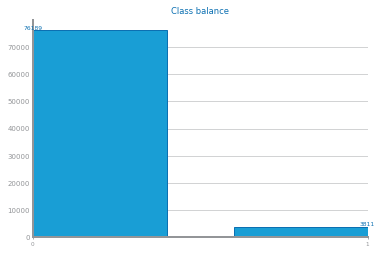

In [82]:
from pandas import read_csv, concat, DataFrame, Series
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_bar_chart

original: DataFrame = read_csv(filepath_or_buffer=f"{filename_train}", sep=",", decimal=".")
test: DataFrame = read_csv(filepath_or_buffer=f"{filename_test}", sep=",", decimal=".")

target_count: Series = original[target].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()

print("Minority class=", positive_class, ":", target_count[positive_class])
print("Majority class=", negative_class, ":", target_count[negative_class])
print(
    "Proportion:",
    round(target_count[positive_class] / target_count[negative_class], 2),
    ": 1",
)
values: dict[str, list] = {
    "Original": [target_count[positive_class], target_count[negative_class]]
}

figure()
plot_bar_chart(
    target_count.index.to_list(), target_count.to_list(), title="Class balance"
)
show()

In [83]:
df_positives: Series = original[original[target] == positive_class]
df_negatives: Series = original[original[target] == negative_class]

<h3>Undersampling</h3>

In [85]:
df_neg_sample: DataFrame = DataFrame(df_negatives.sample(len(df_positives)))
df_under: DataFrame = concat([df_positives, df_neg_sample], axis=0)
df_under.to_csv(f"{path_to_directory}/datasets/{file_tag}_undersampling.csv", index=False)

print("Minority class=", positive_class, ":", len(df_positives))
print("Majority class=", negative_class, ":", len(df_neg_sample))
print("Proportion:", round(len(df_positives) / len(df_neg_sample), 2), ": 1")

Minority class= 1 : 3811
Majority class= 0 : 3811
Proportion: 1.0 : 1


Methodology

{'accuracy': [0.3339, 0.86295], 'recall': [0.7390350877192983, 0.8837719298245614], 'precision': [0.04898967873237389, 0.23423423423423423], 'auc': [0.5267891281010573, 0.8728635424479052], 'f1': [0.09188820722563053, 0.37031932000918905]}


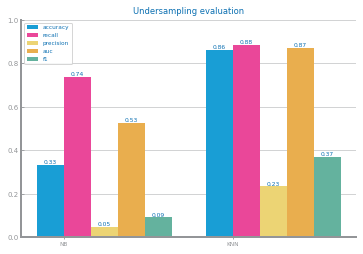

In [86]:
figure()
eval_undersampling: dict[str, list] = evaluate_approach(df_under, test, target=target, metric="recall")
print(eval_undersampling)
plot_multibar_chart(
    ["NB", "KNN"], eval_undersampling, title="Undersampling evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/Set 2 - Undersampling results.png")
show()

<h3>Oversampling</h3>

In [87]:
df_pos_sample: DataFrame = DataFrame(
    df_positives.sample(len(df_negatives), replace=True)
)
df_over: DataFrame = concat([df_pos_sample, df_negatives], axis=0)
df_over.to_csv(f"{path_to_directory}/datasets/{file_tag}_oversampling.csv", index=False)

print("Minority class=", positive_class, ":", len(df_pos_sample))
print("Majority class=", negative_class, ":", len(df_negatives))
print("Proportion:", round(len(df_pos_sample) / len(df_negatives), 2), ": 1")

Minority class= 1 : 76189
Majority class= 0 : 76189
Proportion: 1.0 : 1


Methodology

{'accuracy': [0.2408, 0.89325], 'recall': [0.8223684210526315, 0.8980263157894737], 'precision': [0.04755262490489475, 0.2862635442153093], 'auc': [0.5176909163100543, 0.8955240547933119], 'f1': [0.08990649724286742, 0.43413729128014833]}


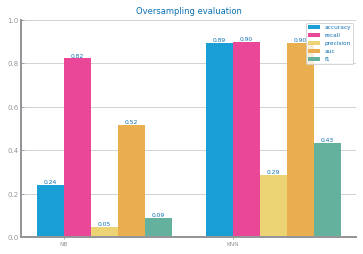

In [88]:
# Because CLASS column was removed
test: DataFrame = read_csv(filepath_or_buffer=f"{filename_test}", sep=",", decimal=".")

figure()
eval_oversampling: dict[str, list] = evaluate_approach(df_over, test, target=target, metric="recall")
print(eval_oversampling)
plot_multibar_chart(
    ["NB", "KNN"], eval_oversampling, title="Oversampling evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/Set 2 - Oversampling results.png")
show()

<h3>SMOTE</h3>

In [89]:
from numpy import ndarray
from pandas import Series
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42

smote: SMOTE = SMOTE(sampling_strategy="minority", random_state=RANDOM_STATE)
y = original.pop(target).values
X: ndarray = original.values
smote_X, smote_y = smote.fit_resample(X, y)
df_smote: DataFrame = concat([DataFrame(smote_X), DataFrame(smote_y)], axis=1)
df_smote.columns = list(original.columns) + [target]
df_smote.to_csv(f"{path_to_directory}/datasets/{file_tag}_smote.csv", index=False)

smote_target_count: Series = Series(smote_y).value_counts()
print("Minority class=", positive_class, ":", smote_target_count[positive_class])
print("Majority class=", negative_class, ":", smote_target_count[negative_class])
print(
    "Proportion:",
    round(smote_target_count[positive_class] / smote_target_count[negative_class], 2),
    ": 1",
)
print(df_smote.shape)

Minority class= 1 : 76189
Majority class= 0 : 76189
Proportion: 1.0 : 1
(152378, 15)


Methodology

{'accuracy': [0.60975, 0.9275], 'recall': [0.6392543859649122, 0.8728070175438597], 'precision': [0.0723414815733962, 0.37370892018779345], 'auc': [0.6237973522448199, 0.9014600888222232], 'f1': [0.1299743618325716, 0.5233399079552925]}


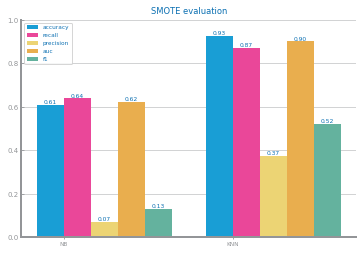

In [91]:
# Because CLASS column was removed
test: DataFrame = read_csv(filepath_or_buffer=f"{filename_test}", sep=",", decimal=".")

figure()
eval_smote: dict[str, list] = evaluate_approach(df_smote, test, target=target, metric="recall")
print(eval_smote)
plot_multibar_chart(
    ["NB", "KNN"], eval_smote, title="SMOTE evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/Set 2 - SMOTE results.png")
show()

### Balancing method evaluation

In [94]:
print(f"Continuing from {best_eval} with mean {best_mean}\n")

evaluations = {f"{best_eval}": best_eval_dict, "undersampling": eval_undersampling, "oversampling": eval_oversampling, "smote": eval_smote}
# evaluations = {f"{best_eval}": best_eval_dict, "oversampling": eval_oversampling, "smote": eval_smote}

aux_best_eval = best_eval
best_mean = -float("inf")
best_mean_NB = -float("inf")
best_mean_KNN = -float("inf")
best_eval = None
best_eval_NB = None
best_eval_KNN = None

for eval_name, eval_dict in evaluations.items():
    # Calculate mean for NB and KNN using generator expressions
    mean_NB = sum(eval_dict[metric][0] for metric in ["accuracy", "recall", "precision", "auc", "f1"]) / 5
    mean_KNN = sum(eval_dict[metric][1] for metric in ["accuracy", "recall", "precision", "auc", "f1"]) / 5
    
    # Print means
    print(f"{eval_name}: Mean NB = {mean_NB}, Mean KNN = {mean_KNN}")

    # Update the best mean for NB
    if mean_NB > best_mean_NB:
        best_mean_NB = mean_NB
        best_eval_NB = eval_name

    # Update the best mean for KNN
    if mean_KNN > best_mean_KNN:
        best_mean_KNN = mean_KNN
        best_eval_KNN = eval_name

# Print the best mean scores
print(f"\nBest Mean NB: {best_mean_NB} from {best_eval_NB}")
print(f"Best Mean KNN: {best_mean_KNN} from {best_eval_KNN}")

if best_mean_NB > best_mean_KNN:
    best_mean = best_mean_NB
    best_eval = best_eval_NB
else:
    best_mean = best_mean_KNN
    best_eval = best_eval_KNN

# Print the best mean scores
print(f"\nContinuing with {best_eval} with mean {best_mean}")

# Determine the filename based on the best evaluations
if best_eval == f"{aux_best_eval}":
    filename_train = f"{path_to_directory}/datasets/{file_tag}_train_lowvar.csv"
    best_eval_dict = eval_lowvar
elif best_eval == "undersampling":
    filename_train = f"{path_to_directory}/datasets/{file_tag}_undersampling.csv"
elif best_eval == "oversampling":
    filename_train = f"{path_to_directory}/datasets/{file_tag}_oversampling.csv"
elif best_eval == "smote":
    filename_train = f"{path_to_directory}/datasets/{file_tag}_smote.csv"

filename_test = filename_test

Continuing from redundant with mean 0.8192534105404515

redundant: Mean NB = 0.45007587183449227, Mean KNN = 0.8192534105404515
undersampling: Mean NB = 0.348120420355672, Mean KNN = 0.644827805303178
oversampling: Mean NB = 0.34366369190208956, Mean KNN = 0.6814402412156486
smote: Mean NB = 0.41502351632314005, Mean KNN = 0.7197631869018337

Best Mean NB: 0.45007587183449227 from redundant
Best Mean KNN: 0.8192534105404515 from redundant

Continuing with redundant with mean 0.8192534105404515


<h3>Best model seems to be with Encoding, Drop Missing Values, no Outliers inputation, no Scaling, droping Reduntant variables and no balancing</h3>